In [1]:
from typing import Sequence, Tuple, List
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import cirq
from ansatz import CylicQAOAAnsatz
from maxcut import edge_operator, maxcut_hamiltonian, bitstring_energy

In [2]:
def optimize_ansatz(ansatz, gamma, beta):
    def objective_callback(vars: np.ndarray):
        assert vars.size % 2 == 0
        
        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        return ansatz.energy(gammas, betas)

    vars0 = np.concatenate((gamma, beta))
    opt_result = minimize(objective_callback, vars0, method="Powell", options={"maxiter": 1_000_000})
    assert opt_result.success, f"Optimizer failed: {opt_result.message}"
    optimized_energy =  objective_callback(opt_result.x)
    gamma_opt = opt_result.x[:gamma.size]
    beta_opt = opt_result.x[gamma.size:]
    return optimized_energy, gamma_opt, beta_opt


def optmize_ansatz_random_start(ansatz, layers, repetitions):
    gammas = np.random.rand(repetitions, layers)
    betas = np.random.rand(repetitions, layers)
    all_outputs = []
    for i in range(repetitions):
        all_outputs.append(optimize_ansatz(ansatz, gammas[i, :], betas[i, :]))
    energies = [out[0] for out in all_outputs]
    i_opt = np.argmin(energies)
    return all_outputs[i_opt]

In [3]:
n = 5
qs = cirq.LineQubit.range(n)
qubit_graph = nx.Graph()
for i in range(len(qs)):
    qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
hamiltonian = maxcut_hamiltonian(qubit_graph)
ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian)

no_reference_energy, gamma, beta = optmize_ansatz_random_start(ansatz, 5, 10)
print(no_reference_energy)

-3.9999105036258698


In [19]:
# Try different reference terms.
p = n - 1 # Number of time steps in Ansatz.
alpha = np.linspace(0.1, 0.0, num=p)

energies = []
for _ in range(100):
    ref_term = np.random.rand(len(qubit_graph.nodes)) > 0.5
    ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, alpha=alpha, reference=ref_term)
    energy, gamma, beta = optmize_ansatz_random_start(ansatz, p, 10)
    energies.append(energy)

In [20]:
print(np.min(energies))

-3.9999708235263824


(array([ 2.,  1.,  0.,  4.,  9., 12.,  9., 22., 30., 11.]),
 array([0.99794839, 0.9981577 , 0.998367  , 0.99857631, 0.99878562,
        0.99899493, 0.99920423, 0.99941354, 0.99962285, 0.99983216,
        1.00004146]),
 <BarContainer object of 10 artists>)

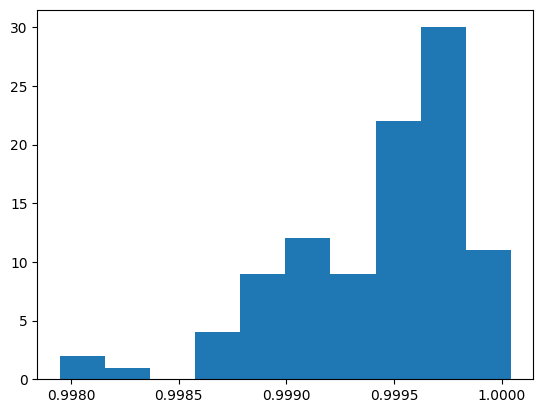

In [21]:
plt.hist(np.array(energies) / no_reference_energy)

In [9]:
rounds = 3
p = 2
reference = [True] * len(qubit_graph.nodes)
alpha = np.linspace(2.0, 0.0, num=p)
for i in range(rounds):
    print("i = ", i)
    print("reference = ", reference)
    ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian, reference=reference, alpha=alpha)
    energy, gamma, beta = optmize_ansatz_random_start(ansatz, p, 10)
    print("Energy = ", energy)
    sampled_bitstrings = ansatz.sample_bitstrings(gamma, beta, 1000)
    print(sampled_bitstrings.shape)
    energies = [bitstring_energy(sampled_bitstrings[i, :], hamiltonian) for i in range(sampled_bitstrings.shape[0])]
    i_best = np.argmin(energies)
    print("Best energy = ", energies[i_best])
    reference = sampled_bitstrings[i, :]

i =  0
reference =  [True, True, True, True, True]
Energy =  -3.9999122619628906
(1000, 5)
Best energy =  -4.0
i =  1
reference =  [1 1 0 1 0]
Energy =  -3.9995846152305603
(1000, 5)
Best energy =  -4.0
i =  2
reference =  [1 0 1 0 1]
Energy =  -3.9996904134750366
(1000, 5)
Best energy =  -4.0
